# **Predicting Bike Sharing Demand**
In this project, We develop a machine learning model to predict daily bike rentals for a city bike-sharing program. This information can be used for optimizing bike distribution, staffing, and overall program efficiency.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
PATH = "/content/AL_and_ML"

In [3]:
df_raw = pd.read_csv(f'{PATH}/hour.csv')
print(df_raw.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


<Axes: xlabel='dteday'>

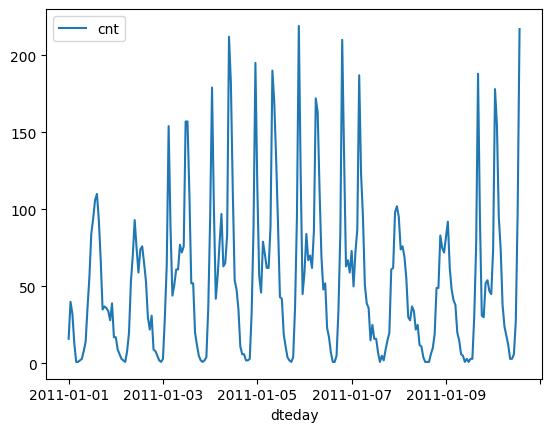

In [4]:
#first 10 days data and bikes rented
df_raw[:24*10].plot(x='dteday', y='cnt')

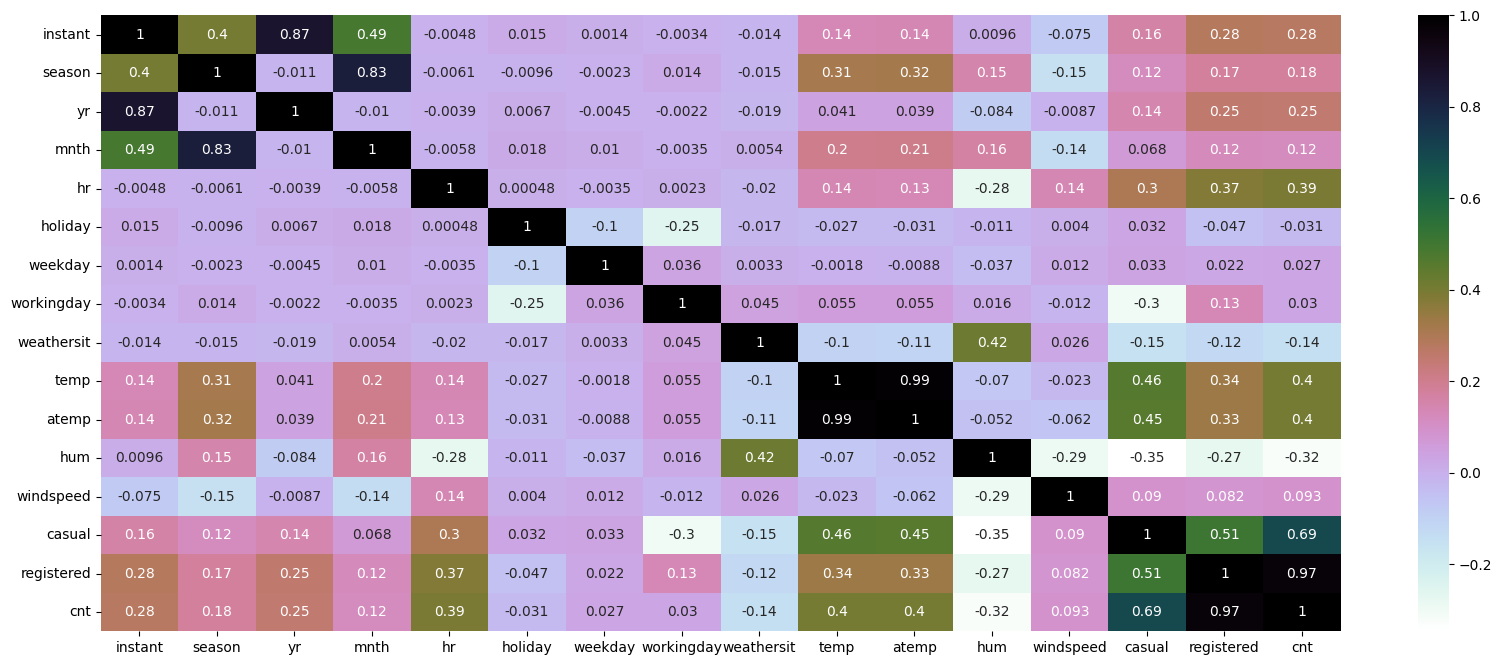

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter df_raw to include only numeric columns
numeric_df_raw = df_raw.select_dtypes(include='number')

# Calculate the correlation matrix of the filtered data frame
correlation_matrix = numeric_df_raw.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='cubehelix_r')
plt.show()

In [6]:
# Printing the unique values stored by data
col_list = list(df_raw.columns.values)
for i in col_list:
    print(i)
    print(eval("df_raw." + i + ".unique()"))

instant
[    1     2     3 ... 17377 17378 17379]
dteday
['2011-01-01' '2011-01-02' '2011-01-03' '2011-01-04' '2011-01-05'
 '2011-01-06' '2011-01-07' '2011-01-08' '2011-01-09' '2011-01-10'
 '2011-01-11' '2011-01-12' '2011-01-13' '2011-01-14' '2011-01-15'
 '2011-01-16' '2011-01-17' '2011-01-18' '2011-01-19' '2011-01-20'
 '2011-01-21' '2011-01-22' '2011-01-23' '2011-01-24' '2011-01-25'
 '2011-01-26' '2011-01-27' '2011-01-28' '2011-01-29' '2011-01-30'
 '2011-01-31' '2011-02-01' '2011-02-02' '2011-02-03' '2011-02-04'
 '2011-02-05' '2011-02-06' '2011-02-07' '2011-02-08' '2011-02-09'
 '2011-02-10' '2011-02-11' '2011-02-12' '2011-02-13' '2011-02-14'
 '2011-02-15' '2011-02-16' '2011-02-17' '2011-02-18' '2011-02-19'
 '2011-02-20' '2011-02-21' '2011-02-22' '2011-02-23' '2011-02-24'
 '2011-02-25' '2011-02-26' '2011-02-27' '2011-02-28' '2011-03-01'
 '2011-03-02' '2011-03-03' '2011-03-04' '2011-03-05' '2011-03-06'
 '2011-03-07' '2011-03-08' '2011-03-09' '2011-03-10' '2011-03-11'
 '2011-03-12' '2011

##Data Preprocessing

In [7]:
# Presence of null values
df_raw= df_raw.fillna(np.nan)
total = df_raw.isnull().sum().sort_values(ascending=False)

percent = (df_raw.isnull().sum()/df_raw.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
display(missing_data.head(5))

,Total,Percent
instant,0,0.0
weathersit,0,0.0
registered,0,0.0
casual,0,0.0
windspeed,0,0.0


In [8]:
#Catagorical Variables to one hot encoding
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(df_raw[each], prefix=each, drop_first=False)
    df_raw = pd.concat([df_raw, dummies], axis=1)

df_raw.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,False,False,False,False,False,False,False,False,False,True
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,False,False,False,False,False,False,False,False,False,True
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,False,False,False,False,False,False,False,False,False,True
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,False,False,False,False,False,False,False,False,False,True
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,False,False,False,False,False,False,False,False,False,True


In [9]:
print(df_raw.dtypes)

instant       int64
dteday       object
season        int64
yr            int64
mnth          int64
              ...  
weekday_2      bool
weekday_3      bool
weekday_4      bool
weekday_5      bool
weekday_6      bool
Length: 68, dtype: object


In [ ]:
# dropping 'season', 'weathersit', 'mnth', 'hr', 'weekday'
# as we have created corresponding catagorical variables

# instant as it is like id, 'atemp' as correlation exists between temp and atemp
# 'workingday' as weekday encompasses all the information of it basically (1 or 0)

# 'dteday' because we have feature columns for mnth, hr, day
fields_to_drop = ['instant', 'season', 'weathersit', 'atemp', 'workingday',
                  'weekday', 'mnth', 'hr', 'dteday']
df_raw = df_raw.drop(fields_to_drop, axis=1)
df_raw.head()

To make training the network easier, we'll standardize each of the continuous variables.

In [11]:
# Scaling continous features
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = df_raw[each].mean(), df_raw[each].std()
    scaled_features[each] = [mean, std]
    df_raw.loc[:, each] = (df_raw[each] - mean)/std

## Splitting data to train, test and validation set

In [12]:
# Save data for approximately the last 21 days
test_data = df_raw[-21*24:]
# Now remove the test data from the data set
df_raw = df_raw[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = df_raw.drop(target_fields, axis=1), df_raw[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained.

In [13]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [14]:
print(train_features.shape)
print(train_targets.shape)
print(len(val_features))
print(len(test_data))

(15435, 56)
(15435, 3)
1440
504


In [15]:
# since we have 3 target column we choose total ie 'cnt' (count)
print(train_targets['cnt'].head())

0   -0.956312
1   -0.823998
2   -0.868103
3   -0.972851
4   -1.039008
Name: cnt, dtype: float64


In [16]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

# MODEL BUILDING
Random Forrest

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

parameters = {'max_depth':[30, 35, 40, 45]}
regr = RandomForestRegressor(random_state=0, n_estimators=200).fit(train_features, train_targets['cnt'])
clf = GridSearchCV(regr, parameters, cv=5, n_jobs=-1)

In [18]:
regr.score(train_features,train_targets['cnt'])

0.9897323086571445

In [19]:
val_y = regr.predict(val_features)
r2_score(val_targets['cnt'], val_y)

0.8221260507262244

Mean Squared Error (MSE): 2292.193261488421
R-squared (R2): 0.9276120800348046


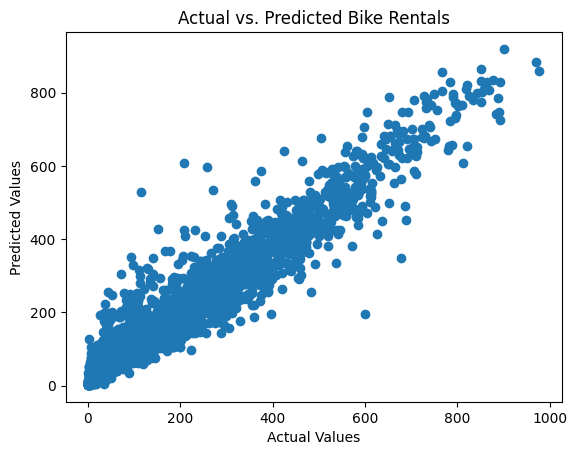

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
df = pd.read_csv('/content/AL_and_ML/hour.csv')

# Drop irrelevant columns
df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)

# Convert categorical columns to dummy variables (one-hot encoding)
df = pd.get_dummies(df, columns=['season', 'mnth', 'hr', 'weekday', 'weathersit'])

# Split the data into features and target
X = df.drop('cnt', axis=1).values
y = df['cnt'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Bike Rentals')
plt.show()


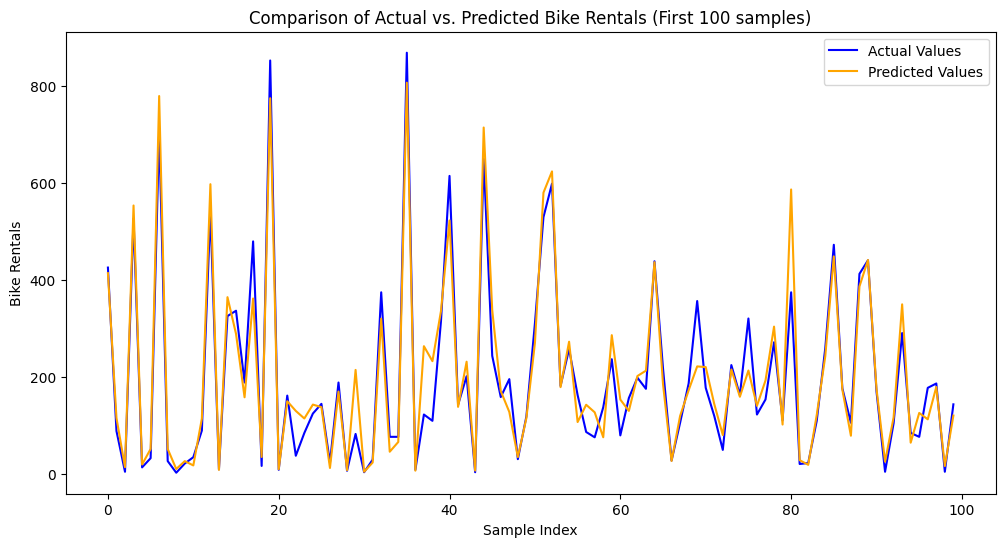

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual Values', color='blue')
plt.plot(y_pred[:100], label='Predicted Values', color='orange')
plt.xlabel('Sample Index')
plt.ylabel('Bike Rentals')
plt.title('Comparison of Actual vs. Predicted Bike Rentals (First 100 samples)')
plt.legend()
plt.show()